In [1]:
from math import *
import random

In [72]:
landmarks=[[20.0,20.0],[80.0,80.0],[20.0,80.0],[80.0,20.0]]
world_size=100.0

In [79]:
class robot:
    def __init__(self):
        self.x=random.random()*world_size
        self.y=random.random()*world_size
        self.orientation=random.random()*2.0*pi
        self.forward_noise=0.0
        self.turn_noise=0.0
        self.sense_noise=0.0
        
    def set(self,new_x,new_y,new_orientation):
        if (new_x<0 or new_x>= world_size):
            raise ValueError ('X coordinate out of bound' )
        if (new_y<0 or new_y>= world_size):
            raise ValueError ('Y coordinate out of bound')
        if (new_orientation<0 or new_orientation >=(2*pi)):
            raise ValueError ('Orientation must be in [0..2pi]')
        
        self.x=float(new_x)
        self.y=float(new_y)
        self.orientation=float(new_orientation)
     
    def set_noise(self,new_f_noise,new_t_noise,new_s_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.forward_noise = float(new_f_noise);
        self.turn_noise    = float(new_t_noise);
        self.sense_noise   = float(new_s_noise);
        
    def sense(self):
        Z=[]
        for i in range(len(landmarks)):
            dist=sqrt((self.x-landmarks[i][0])**2+(self.y-landmarks[i][1])**2)
            dist +=random.gauss(0.0,self.sense_noise)
            Z.append(dist)
        return Z
    def move(self,turn,forward):
        if (forward<0):
            raise ValueError('Robot cant move backwards')   
        
        # turn, and add randomness to the turning command
        orientation=self.orientation+float(turn)+random.gauss(0.0, self.turn_noise)
        orientation %=2*pi
        
        # move, and add randomness to the motion command
        dist=float(forward)+random.gauss(0.0,self.forward_noise)
        x=self.x+(cos(orientation)*dist)
        y=self.y+(sin(orientation)*dist)
        x=x%world_size  # cyclic truncate
        y=y%world_size

        # set particle
        res=robot()
        res.set(x,y,orientation)
        res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
        return res
    def Gaussian(self,mu,sigma,x):
       # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
        return exp(-((mu-x)**2)/sigma**2/2.0)/sqrt(2.0*pi*(sigma**2))

    def measurement_prob(self,measurement):
        
        # calculates how likely a measurement should be
        prob=1.0
        for i in range(len(measurement)):
            dist = sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            prob *=self.Gaussian(dist,self.sense_noise,measurement[i])
        return prob
    
    def __repr__(self):
        return '[x=%.6s y=%.6s orient=%.6s]' % (str(self.x), str(self.y), str(self.orientation))


In [80]:
def eval(r,p):
    sum=0.0;
    for i in range(len(p)):# calculate mean error
        dx=(p[i].x-r.x+(world_size/2.0))%world_size-(world_size/2.0)
        dy=(p[i].y-r.y+(world_size/2.0))%world_size-(world_size/2.0)
        err=sqrt(dx*dx+dy*y)
        sum +=err
    return sum/float(len(p))

#### Example
* Make a robot called myrobot that starts at
 coordinates 30, 50 heading north (pi/2).
* Have your robot turn clockwise by pi/2, move
 15 m, and sense. 
* Then have it turn clockwise by pi/2 again, move 10 m, and sense again.

 Your program should print out the result of
 your two sense measurements.


In [81]:
myrobot = robot()
myrobot.set(30,50,pi/2)
print(myrobot)
myrobot=myrobot.move(-pi/2,15)
print (myrobot.sense())
myrobot=myrobot.move(-pi/2,10)
print (myrobot.sense())

[x=30.0 y=50.0 orient=1.5707]
[39.05124837953327, 46.09772228646444, 39.05124837953327, 46.09772228646444]
[32.01562118716424, 53.150729063673246, 47.16990566028302, 40.311288741492746]


## Creating Particles

In [82]:
N=1000
p=[]
for i in range(N):
    x=robot()
    p.append(x)
print(len(p))


1000


I now want you to take each of these particles and simulate robot motion. Depending on the heading direction, this might yield a different direction. So, each of these particles shall first turn by 0.1 and then move by 5 meters.

In [83]:
p2=[]
for i in range(N):
    p2.append(p[i].move(.1,5.0))
p=p2

## Importance Weight

What I want you to program now is a way to assign importance weights to each of the particles. I want you to make a list called w of 1000 elements where each element on the list contains a number. The number is proportional to how important that particle is.

In [86]:
N=1000
p=[]
Z = myrobot.sense()

for i in range(N):
    x=robot()
    x.set_noise(0.05,0.05,5.0)
    p.append(x)
print(len(p))

p2=[]
for i in range(N):
    p2.append(p[i].move(.1,5.0))
p=p2
w=[]
for i in range(N):
    w.append(p[i].measurement_prob(Z))
print(w)

1000
[1.6137477670886383e-31, 4.862304434925122e-38, 7.637659796880605e-44, 5.378631723687254e-32, 4.710824176979015e-17, 1.738143309957514e-08, 1.8509064482059014e-05, 8.333122815839675e-53, 6.806225540745936e-20, 2.8711396091023275e-36, 5.061874813226885e-11, 3.939505398023066e-30, 1.684838839613079e-38, 4.367530505138697e-64, 3.023766571281376e-06, 1.0004295271227166e-12, 4.330727722264938e-27, 7.971288280859692e-37, 1.8660021798553047e-43, 6.317427186033909e-32, 9.830687511970595e-07, 2.9732830835564934e-14, 2.6763076014407116e-17, 9.476200035227451e-14, 2.1045861305392508e-22, 7.119324453949956e-53, 1.2189301829804693e-39, 6.091408821077756e-28, 3.4086997193505087e-12, 1.5689313049614174e-13, 8.908358393899624e-06, 2.56887966796271e-28, 1.338735192409793e-35, 7.380904122958354e-71, 4.714953229929867e-20, 8.388856613595396e-15, 3.2974942507979464e-31, 7.133008193533914e-30, 6.613665133633003e-27, 2.752030734229199e-24, 1.7347680981440455e-13, 2.2267984905031486e-71, 4.5382168776388

# Resampling

**to make sure you understand this let me ask you a couple of quizzes.Suppose we have 5 particles with the following importance weights: 0.6, 1.2, 2.4, 0.6, 1.2. If I, in the process of resampling, randomly draw a particle in accordance to the normalized importance weights. What is the probability of drawing P1,P2, P4 and P5? **



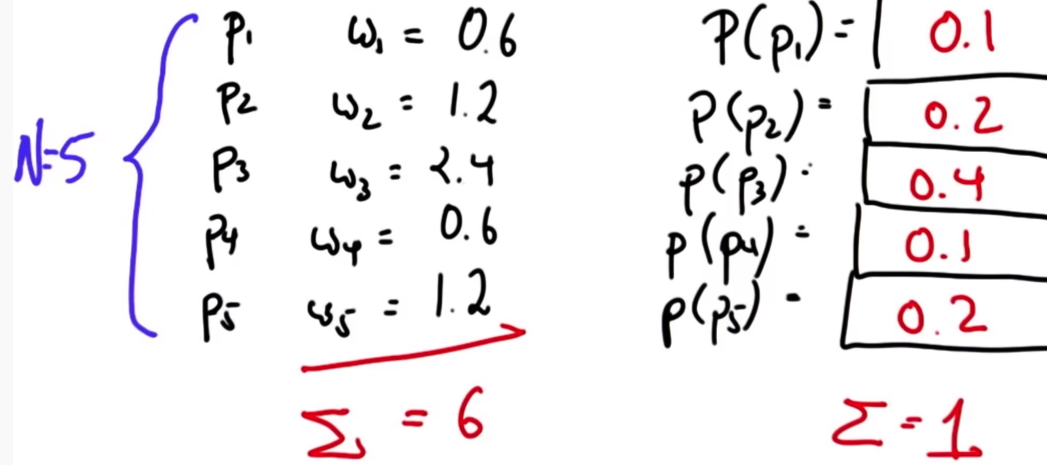

And the answer is 0.1, 0.2, 0.4, 0.1, and 0.2

to see we just have to normalize the importance weights.
* The sum of the numbers is 6.

* we divide 0.6 by 6. We get 0.1.
* 1.2 divided by 6 is 0.2.

* 2.4 divided by 6 is 0.4.

* Obviously those over here add up to 1.


 **Is it possible that P1 is never sampled in the resampling step? Yes or no? **

the answer is yes, in the random resampling process something with an importance weight of 0.1 is actually
quite unlikely to be sampled into the next data set. 

**Is it possible that P3 is never sampled in the resampling step? **

The answer is yes, again.Even though this importance weight over here is large,it could happen that in each of the 5 resampling steps
we pick one of the other 4. 

**what is the probability of never sampling P3? To answer this question assume we make a new particle set with N=5 new particles where particles are drawn independently and with replacement.**

And the answer is 0.0777 approximately, and the way to obtain this is for this particle to never to be drawn in the resampling phase, we always have to draw one of the 4 particles p1,p2,p4,p5 and those together have a probability of 0.6 to be drawn, which contrasts to the 0.4 for P3. 
So for 5 independent samplings to draw one of those 4 (p1, p2, p4, p5),we get a total probability of 0.6 <sup>5</sup> which is approximately 0.0777. 

Put differently, there is about a 7.7% chance that the  p3 particle is missing, 
but with almost 93% probability we'd have the p3 particle included. 

If we have for the question instead of P3,  P1, which has a much smaller probability of being drawn, then this 0.07 will be as large as 0.59,  which is 0.9 6 <sup>5</sup>. Now this means with about 60% chance we will lose particle 1, and only with a 40% chance it will include it. 
 
Put differently, the particles with small importance weights will survive at a much lower rate than the ones with larger importance weights, which is exactly what we wish to get from the resampling step. 

